In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import roc_curve, confusion_matrix, auc,plot_confusion_matrix,precision_recall_curve, accuracy_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
employee=pd.read_csv("employee_retention_data.csv")

In [4]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [5]:
employee.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [6]:
#It is not reasonable if an employee has 99 years of working experience. Find outliers and remove the records
#sorted(employee.seniority,reverse=True)
employee=employee[(employee.seniority!=99) & (employee.seniority!=98)]

**Question 1.**
 
Construct a table with three columns: date, employee_headcount,company_id

In [7]:
employee['join_date']=employee['join_date'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

In [8]:
employee['quit_date']=employee['quit_date'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d') if pd.notna(d) else '2000-1-1')

In [9]:
employee_join=employee.groupby(['company_id','join_date']).agg({'employee_id':'count'})
employee_join=employee_join.reset_index()

In [10]:
dates = (pd.date_range('1/24/2011', end='12/13/2015', freq='D')).tolist()*12
date_length=len(dates)/12
company=[1,2,3,4,5,6,7,8,9,10,11,12]
company=np.repeat(company,date_length)
dates_df=pd.DataFrame({'date':dates,'company_id':company})

In [11]:
employee_join_date=employee_join.merge(dates_df,left_on=['company_id','join_date'],right_on=['company_id','date'],how='right')
employee_join_date=employee_join_date.drop(['join_date'],axis=1)

In [12]:
employee_quit=employee.groupby(['company_id','quit_date']).agg({'employee_id':'count'})
employee_quit=employee_quit.reset_index()

In [13]:
employee_quit_date=employee_quit.merge(dates_df,left_on=['company_id','quit_date'],right_on=['company_id','date'],how='right')
employee_quit_date=employee_quit_date.drop(['quit_date'],axis=1)

In [14]:
employee_join_quit=pd.merge(employee_join_date,employee_quit_date, on=['company_id','date'])

In [15]:
employee_join_quit.fillna({'employee_id_x':0, 'employee_id_y':0}, inplace=True)

In [16]:
employee_join_quit['employee_count']=employee_join_quit.employee_id_x-employee_join_quit.employee_id_y

In [17]:
employee_join_quit['employee_headcount'] = employee_join_quit.groupby(['company_id'])['employee_count'].cumsum()

In [21]:
employee_join_quit

,company_id,employee_id_x,date,employee_id_y,employee_count,employee_headcount
0,1,25.0,2011-01-24,0.0,25.0,25.0
1,1,2.0,2011-01-25,0.0,2.0,27.0
2,1,2.0,2011-01-26,0.0,2.0,29.0
3,1,30.0,2011-01-31,0.0,30.0,59.0
4,1,7.0,2011-02-01,0.0,7.0,66.0
...,...,...,...,...,...,...
21415,12,0.0,2015-12-09,0.0,0.0,12.0
21416,12,0.0,2015-12-10,0.0,0.0,12.0
21417,12,0.0,2015-12-11,0.0,0.0,12.0
21418,12,0.0,2015-12-12,0.0,0.0,12.0


In [19]:
employee_headcount=employee_join_quit.drop(['employee_id_x','employee_id_y','employee_count'],axis=1)

In [20]:
employee_headcount

,company_id,date,employee_headcount
0,1,2011-01-24,25.0
1,1,2011-01-25,27.0
2,1,2011-01-26,29.0
3,1,2011-01-31,59.0
4,1,2011-02-01,66.0
...,...,...,...
21415,12,2015-12-09,12.0
21416,12,2015-12-10,12.0
21417,12,2015-12-11,12.0
21418,12,2015-12-12,12.0


**Question 2.**

What are the main factors that drive employee churn?

In [22]:
employee_join_quit['date_month']=employee_join_quit['date'].apply(lambda d: d.month)

In [23]:
employee_join_quit['date_year']=employee_join_quit['date'].apply(lambda d: d.year)

In [24]:
employee_join_quit['week_of_year']=employee_join_quit['date'].apply(lambda d: d.isocalendar()[1])

In [25]:
employee_join_quit['quit_ratio']=employee_join_quit['employee_id_y']/employee_join_quit['employee_headcount']

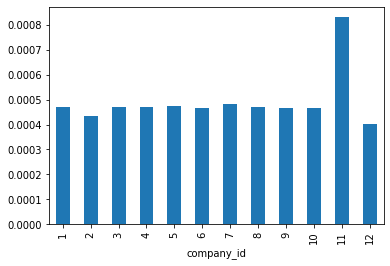

In [26]:
quit_ratio=employee_join_quit.groupby('company_id')['quit_ratio'].mean()
ax=quit_ratio.plot.bar()
#employee in company 11 has a higher ratio of quitting, while the other company has similar quitting rate

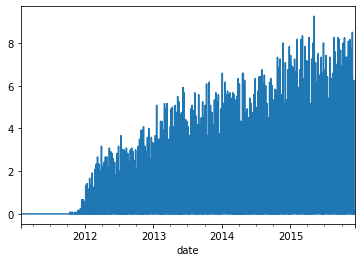

In [27]:
quit_daily=employee_join_quit.groupby('date')['employee_id_y'].mean()
ax=quit_daily.plot.line()
#the number of employees who quit shows an upward trend from 2011 to 2015

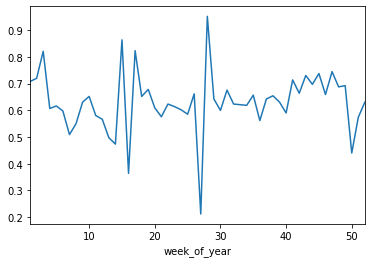

In [28]:
quit_week_of_year=employee_join_quit.groupby('week_of_year')['employee_id_y'].mean()
quit_week_of_year
ax=quit_week_of_year.plot.line()
#The spike in employee quitting happened at the 15th and 28th week.

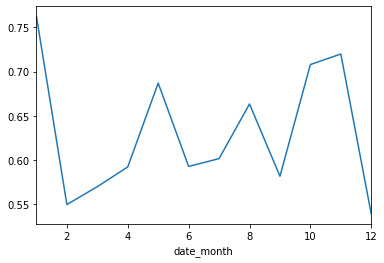

In [29]:
quit_monthly=employee_join_quit.groupby('date_month')['employee_id_y'].mean()
ax=quit_monthly.plot.line()
#Very few people quit their jobs in December but a lot in January, probably because December is the holiday month.

In [30]:
employee['employment_length']=employee['quit_date']-employee['join_date']
employee['employment_length']=employee['employment_length'].apply(lambda d: d.days)

In [31]:
employee_quitted=employee[employee.employment_length>=0]

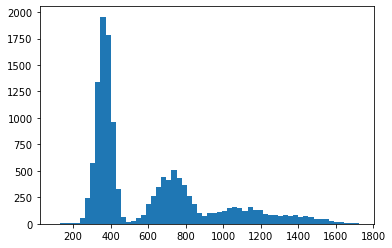

In [32]:
employment_length=employee_quitted['employment_length'].dropna()
ax=plt.hist(employment_length,bins=60)
#Employees tend to quit at the anniversaries. A lot of quit after 1 year.

Build a Random Forest Model：

In [33]:
#define employee churn as- employees who quit within 400 days of employement as early quitters, 
#others as non-early_quitters

employee['early_quitter']=(employee['employment_length']<=400)& (
    employee['employment_length']>=0)
employee.loc[employee['employment_length'] < 0, 'employment_length'] = 1800
employee['early_quitter']=employee['early_quitter'].astype(int)
employee['join_month']= employee['join_date'].apply(lambda d: d.month)    
employee['quit_month']= employee['quit_date'].apply(lambda d: d.month) 
employee['quit_weekofyear']= employee['quit_date'].apply(lambda d: d.isocalendar()[1])
#remove employees who joined the company less than 400 days as of 2015-12-13 (last day of the dataset)
employee=employee[employee['join_date']<=(datetime.strptime('2015-12-13', '%Y-%m-%d')- timedelta(days=400))]

In [34]:
employee_cleaned=pd.get_dummies(employee,drop_first=True)

In [35]:
#employee_cleaned

In [36]:
X=employee_cleaned.drop(['early_quitter','join_date','quit_date','employment_length'],axis=1)
y=employee_cleaned['early_quitter']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=27)

In [37]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
y_pred_prob=clf.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_prob)
print(auc)

0.7915017704644866
0.8762946708982116


In [38]:
confusion_matrix(y_test, y_pred)

array([[2852,  509],
       [ 492,  948]])

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

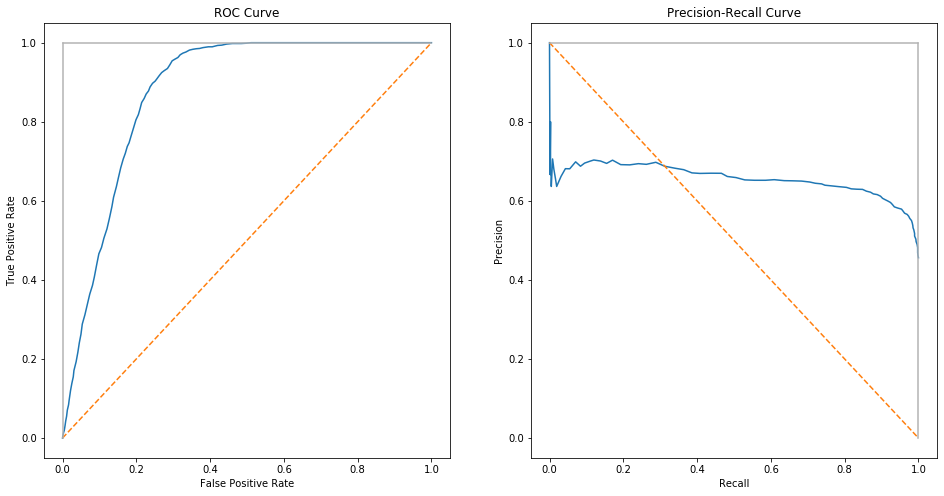

In [40]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Feature ranking:
1. feature 6 (0.281023)
2. feature 4 (0.173001)
3. feature 5 (0.150314)
4. feature 0 (0.118906)
5. feature 3 (0.114574)
6. feature 2 (0.079267)
7. feature 1 (0.050813)
8. feature 10 (0.007761)
9. feature 11 (0.007309)
10. feature 9 (0.006361)
11. feature 7 (0.005667)
12. feature 8 (0.005002)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

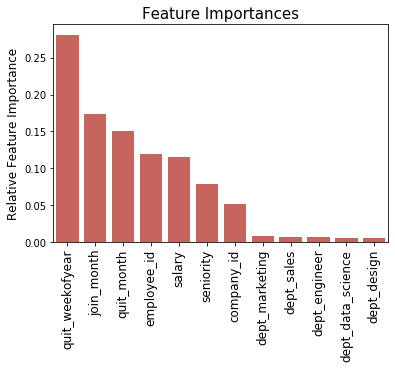

In [41]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=90)

In [42]:
X=X.drop(['quit_weekofyear','join_month','quit_month','employee_id'],axis=1)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=27)

In [43]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
y_pred_prob=clf.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,y_pred_prob)
print(auc)

0.6215371797542179
0.539293860954081


Feature ranking:
1. feature 2 (0.621606)
2. feature 1 (0.243611)
3. feature 0 (0.120637)
4. feature 5 (0.003115)
5. feature 6 (0.002926)
6. feature 3 (0.002745)
7. feature 4 (0.002699)
8. feature 7 (0.002661)


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

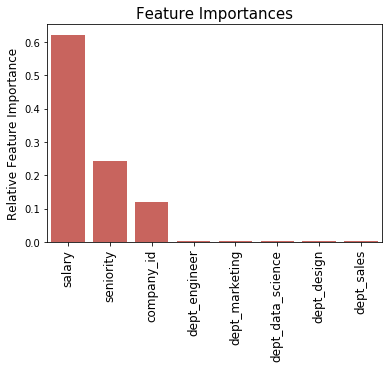

In [44]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=90)

Further Analysis:

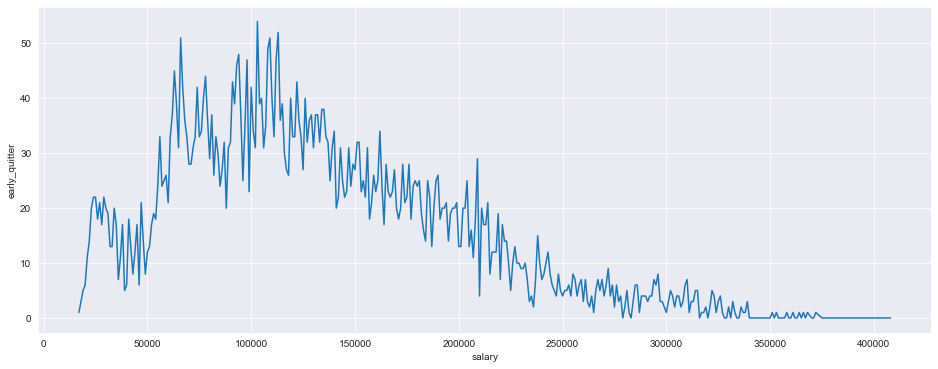

In [50]:
quitter_salary=pd.DataFrame(employee_cleaned.groupby('salary')['early_quitter'].sum(),index=None)
quitter_salary=quitter_salary.reset_index()
sns.set_style('darkgrid')
plt.figure(figsize=(16, 6))
sns.lineplot(x='salary',y='early_quitter',data=quitter_salary)

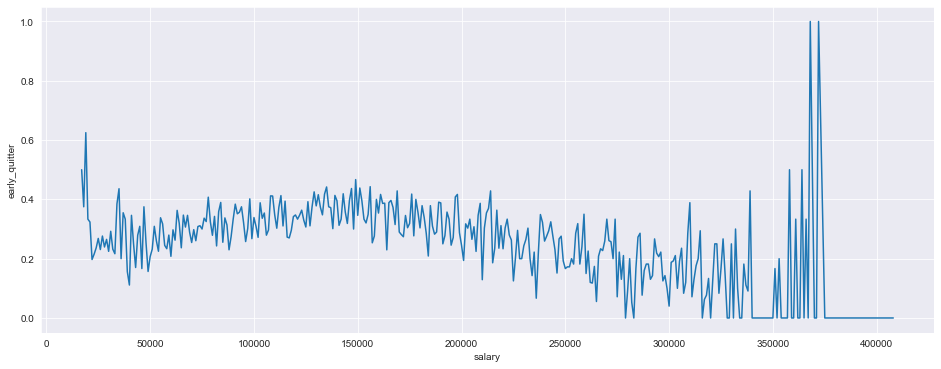

In [53]:
quitter_salary=pd.DataFrame(employee_cleaned.groupby('salary')['early_quitter'].mean(),index=None)
quitter_salary=quitter_salary.reset_index()
sns.set_style('darkgrid')
plt.figure(figsize=(16, 6))
sns.lineplot(x='salary',y='early_quitter',data=quitter_salary)

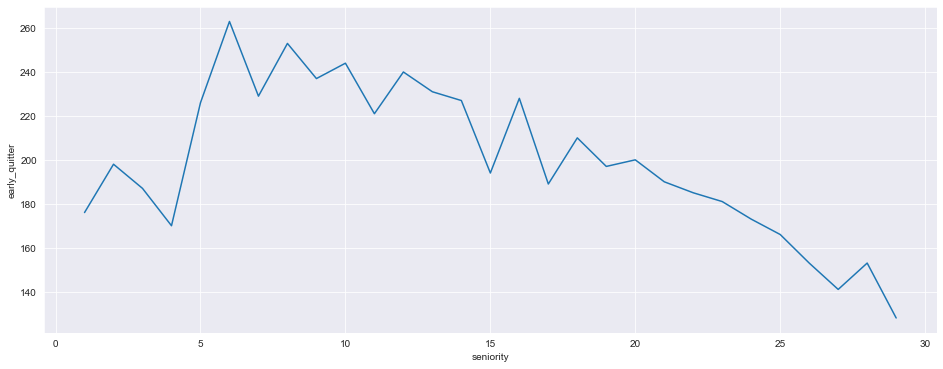

In [51]:
quitter_seniority=pd.DataFrame(employee_cleaned.groupby('seniority')['early_quitter'].sum(),index=None)
quitter_seniority=quitter_seniority.reset_index()
plt.figure(figsize=(16, 6))
sns.lineplot(x='seniority',y='early_quitter',data=quitter_seniority)

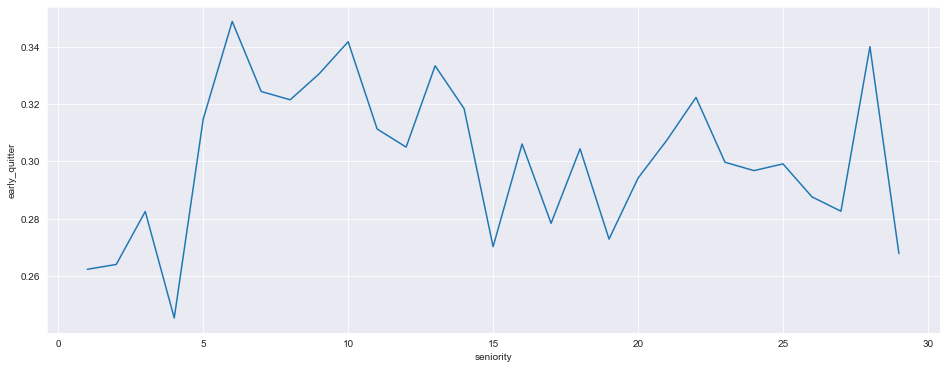

In [54]:
quitter_seniority=pd.DataFrame(employee_cleaned.groupby('seniority')['early_quitter'].mean(),index=None)
quitter_seniority=quitter_seniority.reset_index()
plt.figure(figsize=(16, 6))
sns.lineplot(x='seniority',y='early_quitter',data=quitter_seniority)

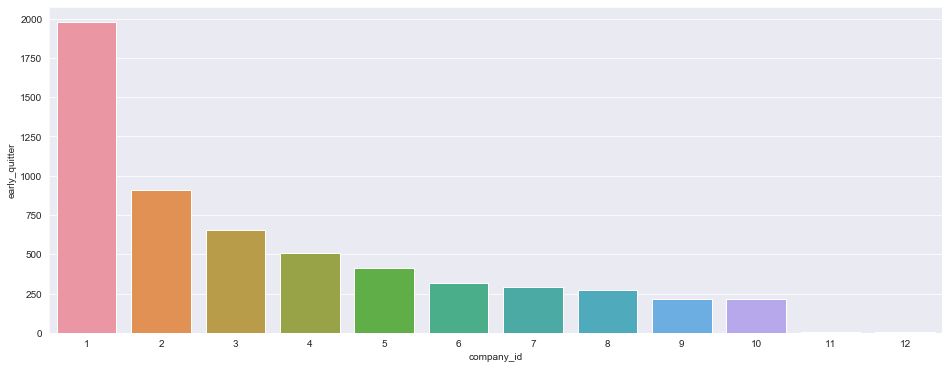

In [52]:
quitter_company=pd.DataFrame(employee_cleaned.groupby('company_id')['early_quitter'].sum(),index=None)
quitter_company=quitter_company.reset_index()
plt.figure(figsize=(16, 6))
sns.barplot(x='company_id',y='early_quitter',data=quitter_company)

Conclusions:

1. Salary, Seniority and company_id are the main factors that determines employee churn. Salary is the top 1.


2. From the further analysis, it is found that employees with the extremely high (above \\$350,000) and low (below \\$50,000) salaries has higher rate of being the early quitters. However, the total number of employees who quit early is higher in the middle of the salary range, highest around \\$100,000. Because of the structure of companies, most employees have salaries in the mid-range. Companies could conduct further analysis into why employees with around \$100,000 tend to quit early, and understand if competitor companies offer higher salaries.


3. Employees with around 5, 10 and 28 years of experiences are most likely to be early quitters. On an aggregate basis, total number of employees who quit early is the highest at 5 year.


4. Company 1 has the highest employee churn count, but company 11 and 12 has slightly higher employee churn rate compared to other companies. Company 1 is a large company with many employees; company 11 and 12 may want to investigate the reason behind the higher rate compared to the peer companies.


5. From the plots, we found that employees has a higher rate of quitting in January and May every year, and very low quitting rate in December. It is likely because the first half of the year is the typical hiring season. In addition, people usually quit around their working anniversaries, especially aroundthe 1st year anniversary. Since 1 year of working in a company is usually enough for the employee to decide if he/she wants long-term development in the company.


6. Another piece of information that would be helpful for the analysis would be the employee's performance review score at the company.

    